## 0. Install Dependencies

In [1]:
# DON'T use %%capture so you can see if there are errors

import os
os.environ['BNB_CUDA_VERSION'] = '121'  # CUDA 12.1

print("🔧 Step 1: Uninstalling old versions...")
!pip uninstall -y bitsandbytes triton -q

print("\n🔧 Step 2: Installing bitsandbytes with CUDA support...")
!pip install bitsandbytes --no-cache-dir -q

print("\n🔧 Step 3: Installing triton...")
# Don't specify version, let it auto-detect compatible version
!pip install triton -q

print("\n🔧 Step 4: Installing core training libraries...")
!pip install -q \
    transformers==4.44.2 \
    datasets==2.20.0 \
    tokenizers==0.19.1 \
    accelerate==0.34.2 \
    peft==0.12.0 \
    trl==0.9.6 \
    evaluate==0.4.2

print("\n🔧 Step 5: Installing utilities...")
!pip install -q \
    numpy \
    pandas \
    scikit-learn \
    rich \
    pyyaml \
    python-dotenv \
    tqdm

print("\n🔧 Step 6: Installing evaluation libraries...")
!pip install -q --upgrade pydantic
!pip install -q google-genai rouge-score

print("🔧 Installing unsloth...")
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git" -q

print("\n🔧 Step 7: Cleaning up...")
!pip uninstall -y deepspeed 2>/dev/null || true

print("\n" + "="*60)
print("✅ Installation complete!")
print("="*60)
print("⚠️  IMPORTANT: RESTART RUNTIME NOW")
print("   Runtime -> Restart runtime (or Ctrl+M .)")
print("="*60)

🔧 Step 1: Uninstalling old versions...

🔧 Step 2: Installing bitsandbytes with CUDA support...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 238.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 MB 374.4 MB/s eta 0:00:00

🔧 Step 3: Installing triton...

🔧 Step 4: Installing core training libraries...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 116.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 130.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.8/245.8 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import bitsandbytes as bnb
import triton
import numpy as np
import pandas as pd
import unsloth

print(f"✅ PyTorch: {torch.__version__}")
print(f"✅ CUDA available: {torch.cuda.is_available()}")
print(f"✅ bitsandbytes: {bnb.__version__}")
print(f"✅ triton: {triton.__version__}")
print(f"✅ numpy: {np.__version__}")
print(f"✅ pandas: {pd.__version__}")
print(f"✅ unsloth version: {unsloth.__version__}")

✅ PyTorch: 2.9.0+cu126
✅ CUDA available: True
✅ bitsandbytes: 0.49.1
✅ triton: 3.5.0
✅ numpy: 1.26.4
✅ pandas: 2.2.2
✅ unsloth version: 2026.1.4


## 1. Setting Up Environment Variables (Secrets)

In [ ]:
# Create .env file with your API key
import os

# Write .env file
with open('.env', 'w') as f:
    # Add the secrets if needed
    # f.write('GOOGLE_API_KEY=<your_api_key_here>\n')
    # f.write('HF_TOKEN=your_api_key_here\n')

    f.write('OPENAI_API_KEY=\n')
    f.write('HF_TOKEN=\n')

print("✅ .env file created")

# Verify it's loaded
from dotenv import load_dotenv
load_dotenv()
# Show only key names for security
try:
    with open('.env', 'r') as f:
        print("🔑 Keys in .env file:")
        print("="*60)
        for line in f:
            line = line.strip()
            if line and not line.startswith('#'):
                key = line.split('=')[0]
                value_preview = line.split('=')[1][:10] + "..." if '=' in line else ""
                print(f"  {key} = {value_preview}")
        print("="*60)
except FileNotFoundError:
    print("❌ .env file not found")

✅ .env file created
🔑 Keys in .env file:
  OPENAI_API_KEY = sk-proj-j8...
  HF_TOKEN = hf_pPEqySy...


## 2. Environment & GPU Check

In [4]:
import sys
import torch

print("="*60)
print("ENVIRONMENT CHECK")
print("="*60)
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"Device capability: {torch.cuda.get_device_capability(0)}")
    print(f"Total VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("⚠️ WARNING: CUDA not available. Training will be VERY slow on CPU.")

print("="*60)

ENVIRONMENT CHECK
Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA version: 12.6
Device name: Tesla T4
Device capability: (7, 5)
Total VRAM: 14.74 GB


## 3. Seeds & Determinism

Set random seeds for reproducibility (note: full determinism on GPU may not be guaranteed).

In [5]:
import os
import random
import numpy as np
import torch

SEED = 42

# Set environment variable for Python hash seed
os.environ['PYTHONHASHSEED'] = str(SEED)

# Set seeds
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    # Note: These settings may impact performance
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"✅ Seeds set to {SEED} for reproducibility")
print("⚠️ Note: Full determinism on GPU is not guaranteed due to non-deterministic operations")

✅ Seeds set to 42 for reproducibility
⚠️ Note: Full determinism on GPU is not guaranteed due to non-deterministic operations


## 4. Hugging Face Login (Optional)

If you want to push your finetuned adapter to the Hugging Face Hub, uncomment and run the login line below.

You'll need a Hugging Face token with write permissions. Get one at: https://huggingface.co/settings/tokens

In [6]:
os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")
!hf auth login --token $HF_TOKEN

print("ℹ️ Hugging Face login skipped. Uncomment login() to push models to Hub.")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `hf`CLI if you want to set the git credential as well.
Token is valid (permission: write).
The token `finetune` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
ℹ️ Hugging Face login skipped. Uncomment login() to push models to Hub.


## 5. Configuration (Single Source of Truth)

All hyperparameters and settings in one place. **Edit here** to customize your training.

In [7]:
import torch
from pprint import pprint

# Auto-detect compute dtype (BF16 requires compute capability >= 8.0)
use_bf16 = torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8
compute_dtype = torch.bfloat16 if use_bf16 else torch.float16

CONFIG = {
    # Model
    "base_model": "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",
    # Alternative for tighter VRAM: "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
    # For GGUF export, prefer: "meta-llama/Llama-3.2-3B-Instruct" or Mistral models

    # Dataset
    "dataset_name": "Uber-2024-Annual-Report-QA-Pairs",
    "dataset_split": "train",
    "dataset_subsample": 1500,  # Colab-safe: 500 | Local: 1500
    "train_val_split": 0.8,  # 90% train, 10% validation

    # Tokenization
    "max_length": 1024,  # Colab: 512 | Local: 1024

    # Training
    "num_train_epochs": 1,
    "max_steps": 300,  # Colab: 250 | Local: 600
    "per_device_train_batch_size": 1,  # Colab: 1 | Local: 2
    "gradient_accumulation_steps": 64,  # Colab: 64 | Local: 32
    "learning_rate": 2e-5,
    "warmup_ratio": 0.03,
    "logging_steps": 10,
    "save_steps": 200,
    "eval_steps": 100,
    "save_total_limit": 2,

    # LoRA
    "lora_r": 16,
    "lora_alpha": 32,
    "lora_dropout": 0.05,
    "lora_target_modules": ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],

    # Quantization
    "load_in_4bit": True,
    "bnb_4bit_compute_dtype": compute_dtype,
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": True,

    # Output
    "output_dir": "outputs/adapter",
    "push_to_hub": True,

    # Generation
    "max_new_tokens": 128,
    "temperature": 0.0,  # Deterministic
    "do_sample": True,

    # HF credentials
    'hf_username': 'dinod001',
    'hub_model_name': 'Llama-3.2-3B-Uber-Intern-SFT',
}

# Effective batch size
effective_batch_size = CONFIG["per_device_train_batch_size"] * CONFIG["gradient_accumulation_steps"]

print("="*60)
print("CONFIGURATION (COLAB FREE TIER)")
print("="*60)
pprint(CONFIG)
print("="*60)
print(f"Compute dtype: {compute_dtype}")
print(f"Using BF16: {use_bf16}")
print(f"Effective batch size: {effective_batch_size}")
print("="*60)

CONFIGURATION (COLAB FREE TIER)
{'base_model': 'unsloth/Llama-3.2-3B-Instruct-bnb-4bit',
 'bnb_4bit_compute_dtype': torch.float16,
 'bnb_4bit_quant_type': 'nf4',
 'bnb_4bit_use_double_quant': True,
 'dataset_name': 'Uber-2024-Annual-Report-QA-Pairs',
 'dataset_split': 'train',
 'dataset_subsample': 1500,
 'do_sample': True,
 'eval_steps': 100,
 'gradient_accumulation_steps': 64,
 'hf_username': 'dinod001',
 'hub_model_name': 'Llama-3.2-3B-Uber-Intern-SFT',
 'learning_rate': 2e-05,
 'load_in_4bit': True,
 'logging_steps': 10,
 'lora_alpha': 32,
 'lora_dropout': 0.05,
 'lora_r': 16,
 'lora_target_modules': ['q_proj',
                         'k_proj',
                         'v_proj',
                         'o_proj',
                         'gate_proj',
                         'up_proj',
                         'down_proj'],
 'max_length': 1024,
 'max_new_tokens': 128,
 'max_steps': 300,
 'num_train_epochs': 1,
 'output_dir': 'outputs/adapter',
 'per_device_train_batch_size': 1,
 '

## 6. Dataset Loader (+ Fallback)

Load the medical instruction dataset, map fields robustly, and create train/validation splits.

In [8]:
from datasets import load_dataset, Dataset
import json


alpaca_prompt = """Below is an instruction that describes a task, paired with a context and a question. Write a response that appropriately completes the request.

### Instruction:
Answer the question accurately using only the provided context from the Uber 2024 Annual Report.

### Context:
{}

### Question:
{}

### Response:
{}"""

def load_qa_dataset(dataset_name, split, subsample, seed=42):
    """Load QA dataset with robust field mapping and fallback."""
    dataset = load_dataset("json", data_files="/content/train.jsonl", split="train")
    print(f"✅ Created synthetic dataset with {len(dataset)} examples")

    return dataset.select(range(subsample))


def formatting_prompts_func(examples):
    # When batched=True, 'context', 'question', 'answer' are lists of strings
    contexts  = examples["context"]
    questions = examples["question"]
    answers   = examples["answer"]
    texts = []

    # zip iterates over elements of the lists
    for context, question, answer in zip(contexts, questions, answers):
        # The full context, question, and answer strings are passed here
        text = alpaca_prompt.format(context, question, answer)
        texts.append(text)

    return { "text" : texts, }

# Load dataset
dataset = load_qa_dataset(
    CONFIG["dataset_name"],
    CONFIG["dataset_split"],
    CONFIG["dataset_subsample"],
    seed=SEED
)

original_dataset_len = len(dataset) # Store original length for dropped examples calculation

dataset = dataset.map(formatting_prompts_func, batched = True)

print(f"\n📊 Dataset before cleaning: {len(dataset)} examples")

# Drop rows with missing instruction or output
dataset = dataset.filter(lambda x: x["context"] is not None and x["answer"] is not None)

print(f"📊 Dataset after cleaning: {len(dataset)} examples")
print(f"✅ Dropped {original_dataset_len - len(dataset)} examples with missing data\n") # Updated print statement

# Split into train/validation
split_dataset = dataset.train_test_split(
    train_size=CONFIG["train_val_split"],
    seed=SEED
)
train_dataset = split_dataset["train"]
val_dataset = split_dataset["test"]

print(f"📊 Train: {len(train_dataset)} | Validation: {len(val_dataset)}")
print("\n📝 Sample example:")
print(dataset[0]["text"])

Generating train split: 0 examples [00:00, ? examples/s]

✅ Created synthetic dataset with 4583 examples


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]


📊 Dataset before cleaning: 1500 examples


Filter:   0%|          | 0/1500 [00:00<?, ? examples/s]

📊 Dataset after cleaning: 1500 examples
✅ Dropped 0 examples with missing data

📊 Train: 1200 | Validation: 300

📝 Sample example:
Below is an instruction that describes a task, paired with a context and a question. Write a response that appropriately completes the request.

### Instruction:
Answer the question accurately using only the provided context from the Uber 2024 Annual Report.

### Context:
15

15

high quality of service and ethical behavior, and continuing our marketing and public relations efforts. Our brand promotion, reputation building, and media strategies have involved significant costs and may not be successful. We anticipate that other competitors and potential competitors will expand their offerings, which will make maintaining and enhancing our reputation and brand increasingly more difficult and expensive. If we fail to successfully maintain our brand in the current or future competitive environment or if events occur in the future which negatively affect public 

### Preview First 50 Samples

Let's visualize the first 50 samples of the dataset as a dataframe for easy inspection.

In [9]:
import pandas as pd
df = train_dataset.to_pandas()

display(df.head(50))

,context,question,answer,text
0,"or other technical malfunctions; employee, con...",3. Who could be harmed by an actual or perceiv...,"Platform users, shareholders, and certain regu...","Below is an instruction that describes a task,..."
1,Although we pre-authorize forms of payment to ...,1. What is the purpose of pre-authorizing form...,To mitigate our exposure.,"Below is an instruction that describes a task,..."
2,"destruction of, such data could have similar a...",8. What is the main concern outlined in the pr...,The destruction of data.,"Below is an instruction that describes a task,..."
3,The principal considerations for our determina...,6. What are the potential outcomes if transact...,Information not available.,"Below is an instruction that describes a task,..."
4,We are not able to control or predict the acti...,7. Why might the qualification processes not f...,The qualification processes and background che...,"Below is an instruction that describes a task,..."
5,to disclose personal data pursuant to demands ...,6. What effect could a change in jurisdictiona...,The company may risk losing its rights to oper...,"Below is an instruction that describes a task,..."
6,We use a combination of third-party cloud comp...,Where are the co-located data centers located?,The United States and abroad.,"Below is an instruction that describes a task,..."
7,and pricing models at times vary based upon ju...,9. What is the overall tone of the text regard...,The tone is uncertain or cautionary.,"Below is an instruction that describes a task,..."
8,91\n\n91\n\ngeneral corporate insurance costs....,What type of expenses are included in general ...,Certain legal related accruals and expenses.,"Below is an instruction that describes a task,..."
9,"Revenue was $44.0 billion, up 18% year-over-ye...",2. By what percentage did Uber's revenue incre...,18%,"Below is an instruction that describes a task,..."


### Token Length & Truncation Diagnostics

In [10]:
from transformers import BitsAndBytesConfig
import torch
from unsloth import FastLanguageModel

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",               # NF4 requirement
    bnb_4bit_use_double_quant=True,         # Double Quant requirement
)

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",
    max_seq_length = 2048,
    dtype = None,
    load_in_4bit = True,
    quantization_config = bnb_config,
    resume_download = True,
)

==((====))==  Unsloth 2026.1.4: Fast Llama patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

In [11]:
import numpy as np

# Ensure pad token is set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Sample data
sample_size = min(1500, len(train_dataset))
sample_dataset = train_dataset.select(range(sample_size))

# Compute token lengths
token_lengths = []
for example in sample_dataset:
    text = example['text']
    # tokenizer utlizing
    tokens = tokenizer(text, add_special_tokens=True)
    token_lengths.append(len(tokens["input_ids"]))

token_lengths = np.array(token_lengths)

# --- Print results ---
print("="*60)
print("TOKEN LENGTH DIAGNOSTICS")
print("="*60)
print(f"Sample size: {sample_size}")
print(f"Average: {token_lengths.mean():.1f}")
print(f"95th percentile: {np.percentile(token_lengths, 95):.1f}")

truncated = (token_lengths > CONFIG["max_length"]).sum()
print(f"Truncation at {CONFIG['max_length']}: {truncated}/{len(token_lengths)}")
print("="*60)

TOKEN LENGTH DIAGNOSTICS
Sample size: 1200
Average: 310.6
95th percentile: 439.3
Truncation at 1024: 0/1200


### Build SFT Prompts

In [12]:
def chatml_format(context, question, answer=None):
    # System prompt specific to the Uber 2024 Annual Report task
    system_text = "Answer the question accurately using only the provided context from the Uber 2024 Annual Report."

    # Combining Context and Question into the User message
    user_text = f"Context:\n{context}\n\nQuestion:\n{question}"

    messages = [
        {"role": "system", "content": system_text},
        {"role": "user", "content": user_text},
    ]

    # If an answer exists (for training), append it as the Assistant role
    if answer:
        messages.append({"role": "assistant", "content": answer})

    # Construct the final ChatML string with appropriate tokens
    formatted = ""
    for msg in messages:
        formatted += f"<|im_start|>{msg['role']}\n{msg['content']}<|im_end|>\n"

    return formatted

def build_sft_prompt(row):
    """
    Mapping function to apply ChatML formatting to each row of the dataset.
    Uses 'context', 'question', and 'answer' fields from the input row.
    """
    prompt = chatml_format(
        context = row["context"],
        question = row["question"],
        answer = row["answer"]
    )
    return {"text": prompt}

# Apply the mapping to the train and validation datasets
train_dataset = train_dataset.map(build_sft_prompt)
val_dataset = val_dataset.map(build_sft_prompt)

print("✅ Prompts built for SFT in ChatML format")
print("\n📝 Sample formatted prompt:")
print(train_dataset[0]["text"])

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

✅ Prompts built for SFT in ChatML format

📝 Sample formatted prompt:
<|im_start|>system
Answer the question accurately using only the provided context from the Uber 2024 Annual Report.<|im_end|>
<|im_start|>user
Context:
or other technical malfunctions; employee, contractor, or vendor error or malfeasance; government surveillance; or other threats that evolve, and we may incur significant costs in protecting against or remediating cyberattacks. Any actual or perceived failure to maintain the performance, reliability, security, and availability of our products, offerings, and technical infrastructure to the satisfaction of platform users, shareholders and certain regulators would likely harm our reputation and result in loss of revenue from the adverse impact to our reputation and brand, disruption to our business, and our decreased ability to attract and retain Drivers, consumers, merchants, Shippers, and Carriers.

Question:
3. Who could be harmed by an actual or perceived failure in 

## 7. Baseline Inference (BEFORE Finetuning)

Load the base model in 4-bit and run inference on two medical prompts to establish a baseline.

In [13]:
import torch
import time
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# 2. Define ChatML helper function (Ensure this is defined before the loop)
def chatml_format(context, question):
    return f"<|im_start|>system\nYou are an expert assistant for the Uber 2024 Annual Report.<|im_end|>\n<|im_start|>user\nContext: {context}\n\nQuestion: {question}<|im_end|>\n<|im_start|>assistant\n"

# 3. Define Uber-specific test prompts
test_prompts = [
    {
        "title": "Specific Fact Extraction",
        "context": "We have incurred significant losses since inception. We incurred a net loss of $9.1 billion in 2022 and $0.5 billion in 2021. As of December 31, 2023, our accumulated deficit was $32.7 billion.",
        "question": "What was the accumulated deficit of the company as of December 31, 2023?"
    },
    {
        "title": "Risk Factor Reasoning",
        "context": "Our business would be adversely affected if Drivers were classified as employees instead of independent contractors. Such classification would require us to pay for expenses like social security, unemployment insurance, and workers' compensation.",
        "question": "Why would classifying Drivers as employees hurt the company's financials?"
    },
]

print("\n" + "="*60)
print("BASELINE OUTPUTS (UBER REPORT PRE-FINETUNE)")
print("="*60)

# Check VRAM before starting
if torch.cuda.is_available():
    vram_before = torch.cuda.memory_allocated() / 1024**3
    print(f"VRAM usage: {vram_before:.2f} GB\n")

# 4. Run Inference Loop using the base model
for i, test in enumerate(test_prompts, 1):

    # Format the prompt using ChatML
    formatted_prompt = chatml_format(context=test["context"], question=test["question"])

    # Tokenize input
    inputs = tokenizer(formatted_prompt, return_tensors="pt").to("cuda")

    # Generate response
    start_time = time.time()
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=128,      # Limit response length for testing
            use_cache=True,
            temperature=0.1,         # Low temperature for factual consistency
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
    elapsed = time.time() - start_time

    # Decode the full output
    full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract only the assistant's part
    if "assistant" in full_text:
        response = full_text.split("assistant")[-1].strip()
    else:
        response = full_text[len(formatted_prompt):].strip()

    # Calculate metrics
    tokens_generated = outputs.shape[1] - inputs["input_ids"].shape[1]
    tokens_per_sec = tokens_generated / elapsed if elapsed > 0 else 0

    print(f"[{i}] {test['title']}")
    print("-" * 60)
    print(f"Question: {test['question']}")
    print(f"\nResponse:\n{response}")
    print(f"\nLatency: {elapsed:.2f}s | Speed: {tokens_per_sec:.1f} tok/s")
    print("-" * 60)

print("\n" + "="*60)
print("BASELINE TESTING COMPLETE")
print("="*60)


BASELINE OUTPUTS (UBER REPORT PRE-FINETUNE)
VRAM usage: 2.11 GB

[1] Specific Fact Extraction
------------------------------------------------------------
Question: What was the accumulated deficit of the company as of December 31, 2023?

Response:
The accumulated deficit of the company as of December 31, 2023, was $32.7 billion.

Latency: 6.51s | Speed: 3.7 tok/s
------------------------------------------------------------
[2] Risk Factor Reasoning
------------------------------------------------------------
Question: Why would classifying Drivers as employees hurt the company's financials?

Response:
If Uber were to classify its drivers as employees, it would be required to pay various expenses, including:

1. **Social Security**: As an employer, Uber would be responsible for paying Social Security taxes, which include both the employer and employee portions of the tax. This would add to the company's payroll costs.

2. **Unemployment Insurance**: Uber would need to pay unemployment

## 8. Model + LoRA Setup and Training

Prepare the model for k-bit training, apply LoRA, and train with SFTTrainer.

In [ ]:
import os
os.environ["ACCELERATE_USE_DEEPSPEED"] = "false"
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "1"

from unsloth import FastLanguageModel,is_bfloat16_supported
from trl import SFTTrainer, SFTConfig

# 1. Apply LoRA Adapters using Unsloth's optimized method
# No need for separate prepare_model_for_kbit_training as Unsloth handles it
model = FastLanguageModel.get_peft_model(
    model,
    r = CONFIG["lora_r"],
    target_modules = CONFIG["lora_target_modules"],
    lora_alpha = CONFIG["lora_alpha"],
    lora_dropout = CONFIG["lora_dropout"],
    bias = "none",
    use_gradient_checkpointing = "unsloth", # High memory efficiency
    random_state = 3407,
)

model.print_trainable_parameters()

# 2. Training arguments configuration
training_args = SFTConfig(
    output_dir = CONFIG["output_dir"],
    max_steps = CONFIG["max_steps"],
    per_device_train_batch_size = CONFIG["per_device_train_batch_size"],
    gradient_accumulation_steps = CONFIG["gradient_accumulation_steps"],
    learning_rate = CONFIG["learning_rate"],
    warmup_ratio = CONFIG["warmup_ratio"],
    logging_steps = CONFIG["logging_steps"],
    save_steps = CONFIG["save_steps"],
    fp16 = not is_bfloat16_supported(),
    bf16 = is_bfloat16_supported(),
    optim = "paged_adamw_8bit",
    lr_scheduler_type = "cosine",
    max_seq_length = CONFIG["max_length"],
    dataset_text_field = "text",
    report_to = "none",
)

# 3. Initialize Trainer
trainer = SFTTrainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    tokenizer = tokenizer,
)

# 4. Start Training
print("\n🚀 Starting training...\n")
train_result = trainer.train()

print("\n" + "="*60)
print("TRAINING COMPLETE")
print(f"Final Loss: {train_result.metrics.get('train_loss', 0):.4f}")
print("="*60)

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2026.1.4 patched 28 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


trainable params: 24,313,856 || all params: 3,237,063,680 || trainable%: 0.7511


Unsloth: Tokenizing ["text"] (num_proc=4):   0%|          | 0/1200 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=4):   0%|          | 0/300 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


🦥 Unsloth: Padding-free auto-enabled, enabling faster training.

🚀 Starting training...



==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,200 | Num Epochs = 16 | Total steps = 300
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 64
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 64 x 1) = 64
 "-____-"     Trainable parameters = 24,313,856 of 3,237,063,680 (0.75% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
10,2.389000
20,2.148600
30,1.883800
40,1.726700
50,1.660300
60,1.609900
70,1.583400
80,1.578500
90,1.549500
100,1.506800


Step,Training Loss
10,2.389000
20,2.148600
30,1.883800
40,1.726700
50,1.660300
60,1.609900
70,1.583400
80,1.578500
90,1.549500
100,1.506800



TRAINING COMPLETE
Final Loss: 1.5025


### Loss Curve

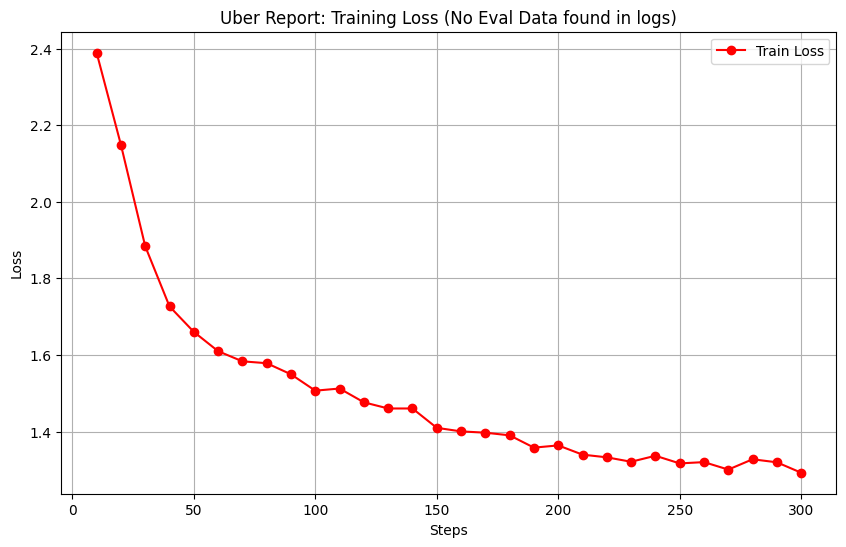

In [ ]:
import matplotlib.pyplot as plt

history = trainer.state.log_history

# Extract training loss
train_steps = [x['step'] for x in history if 'loss' in x]
train_losses = [x['loss'] for x in history if 'loss' in x]

# Extract validation loss (if available)
eval_steps = [x['step'] for x in history if 'eval_loss' in x]
eval_losses = [x['eval_loss'] for x in history if 'eval_loss' in x]

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label='Train Loss', color='red', marker='o')

if eval_losses:
    plt.plot(eval_steps, eval_losses, label='Validation Loss', color='blue', marker='x')
    plt.title('Uber Report: Train vs Validation Loss')
else:
    plt.title('Uber Report: Training Loss (No Eval Data found in logs)')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Manually run evaluation on the validation dataset
eval_results = trainer.evaluate()

print(f"Final Validation Loss: {eval_results['eval_loss']:.4f}")

Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Final Validation Loss: 1.3578


## 9. Save Adapter + Tokenizer

Save the LoRA adapter and tokenizer. Optionally push to Hugging Face Hub.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# 1. Save LoRA Adapters locally
# This saves the trained weights so you can reload them later
print(f"💾 Saving Uber Expert adapter to {CONFIG['output_dir']}...")
model.save_pretrained(CONFIG["output_dir"])
tokenizer.save_pretrained(CONFIG["output_dir"])
print("✅ Adapter and tokenizer saved locally")
model.save_pretrained("/content/drive/MyDrive/uber_model_final")
tokenizer.save_pretrained("/content/drive/MyDrive/uber_model_final")

print("✅ Adapter and tokenizer saved Drive")

# 2. Update Model Card (README.md) for Uber Context
# Updated tags and description to match the Uber 2024 Annual Report task
model_card = f"""---
license: apache-2.0
tags:
- uber-report
- finance
- qlora
- unsloth
- finetuned
---

# Uber 2024 Annual Report Expert (Llama-3.2)

This model is a fine-tuned LoRA adapter based on Llama-3.2, specialized in answering questions about the **Uber 2024 Annual Report**.

## Base Model
- **Base Model:** {CONFIG['base_model']}
- **Method:** QLoRA (4-bit Quantization)

## Training Details
- **Data:** Uber 2024 Annual Report QA Dataset
- **LoRA Rank (r):** {CONFIG['lora_r']}
- **LoRA Alpha:** {CONFIG['lora_alpha']}
- **Max Steps:** {CONFIG['max_steps']}
- **Optimizer:** paged_adamw_8bit

## Usage
This adapter can be loaded using the `PeftModel` class from the `peft` library.
"""

with open(os.path.join(CONFIG["output_dir"], "README.md"), "w") as f:
    f.write(model_card)

print("✅ Uber Expert model card saved")

# 3. Push to Hugging Face Hub (Optional)
# Ensure you have run 'huggingface-cli login' before this
if CONFIG.get("push_to_hub", False):
    repo_name = f"{CONFIG['hf_username']}/{CONFIG['hub_model_name']}"

    print(f"\n📤 Pushing to Hugging Face Hub: {repo_name}")

    # Using Unsloth's optimized push method
    model.push_to_hub(repo_name)
    tokenizer.push_to_hub(repo_name)

    print(f"✅ Pushed to Hub: https://huggingface.co/{repo_name}")
else:
    print("\nℹ️ Hub upload skipped (push_to_hub=False)")

💾 Saving Uber Expert adapter to outputs/adapter...
✅ Adapter and tokenizer saved locally
✅ Adapter and tokenizer saved Drive
✅ Uber Expert model card saved

📤 Pushing to Hugging Face Hub: dinod001/Llama-3.2-3B-Uber-Intern-SFT


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:   1%|1         |  525kB / 48.7MB            

Saved model to https://huggingface.co/dinod001/Llama-3.2-3B-Uber-Intern-SFT


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...mpy4d4o7rz/tokenizer.json:  48%|####8     | 8.33MB / 17.2MB            

No files have been modified since last commit. Skipping to prevent empty commit.


✅ Pushed to Hub: https://huggingface.co/dinod001/Llama-3.2-3B-Uber-Intern-SFT


## 10. Post-Finetune Inference

Load the base model with the finetuned adapter and run the same prompts.

In [14]:
from unsloth import FastLanguageModel
import torch
import time

# 1. Clean memory
torch.cuda.empty_cache()

# 2. Load Model (Unsloth optimized)
finetuned_model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = f"{CONFIG['hf_username']}/{CONFIG['hub_model_name']}",
    max_seq_length = 2048,
    load_in_4bit = True,
)
FastLanguageModel.for_inference(finetuned_model)
print("✅ Model loaded from HuggingFace")

print("\n" + "="*60)
print("POST-FINETUNE")
print("="*60)

for i, test in enumerate(test_prompts, 1):
    prompt = chatml_format(test["context"], test["question"])
    inputs = tokenizer([prompt], return_tensors = "pt").to("cuda")

    start_time = time.time()

    outputs = finetuned_model.generate(
        input_ids = inputs.input_ids,
        attention_mask = inputs.attention_mask,
        max_new_tokens = 64,
        use_cache = True,
        do_sample = False,
        pad_token_id = tokenizer.pad_token_id,
        eos_token_id = tokenizer.eos_token_id
    )
    elapsed = time.time() - start_time

    # 3. Smart Decoding & Cleaning

    raw_response = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
    clean_response = raw_response.split("assistant")[0].split("<")[0].strip()


    if not clean_response: #
        clean_response = raw_response.strip()

    print(f"[{i}] {test['title']}")
    print(f"Question: {test['question']}")
    print(f"Response:\n{clean_response}")
    print(f"Latency: {elapsed:.2f}s")
    print("-" * 60)

==((====))==  Unsloth 2026.1.4: Fast Llama patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


adapter_model.safetensors:   0%|          | 0.00/48.7M [00:00<?, ?B/s]

Unsloth 2026.1.4 patched 28 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


✅ Model loaded from HuggingFace

POST-FINETUNE
[1] Specific Fact Extraction
Question: What was the accumulated deficit of the company as of December 31, 2023?
Response:
$32.7 billion
Latency: 3.93s
------------------------------------------------------------
[2] Risk Factor Reasoning
Question: Why would classifying Drivers as employees hurt the company's financials?
Response:
The company would have to pay for expenses like social security, unemployment insurance, and workers' compensation.
Latency: 3.62s
------------------------------------------------------------


## 11. Quick Evaluation (Sanity Check)

Evaluate the finetuned model using two complementary metrics:

**Evaluation Metrics:**

**1. LLM-as-Judge (OpenAI)**

- Evaluates outputs for accuracy, completeness, clarity, and safety
- Provides a score from 1-5 with detailed reasoning
- Offers nuanced, semantic understanding of model quality

**2. ROUGE-L**

- Measures lexical overlap between prediction and reference
- Objective metric based on longest common subsequence
- Useful for detecting exact matches and paraphrasing

In [15]:
import os
import time
import torch
from rouge_score import rouge_scorer
from unsloth import FastLanguageModel
from openai import OpenAI
from dotenv import load_dotenv


load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

FastLanguageModel.for_inference(finetuned_model)
rouge_scorer_obj = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

# 3. Prompt Formatting
def chatml_format_final(context, question):
    return f"<|im_start|>system\nYou are an expert assistant for the Uber 2024 Annual Report.<|im_end|>\n<|im_start|>user\nContext: {context}\n\nQuestion: {question}<|im_end|>\n<|im_start|>assistant\n"

# 4. LLM Judge Function
def evaluate_with_gpt_judge(question, prediction, target):
    judge_prompt = f"""You are an expert evaluator. Evaluate this AI response based on the Uber 2024 Annual Report.

    QUESTION: {question}
    REFERENCE: {target}
    MODEL OUTPUT: {prediction}

    Provide:
    SCORE: [1-5]
    REASONING: [briefly why]"""

    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": judge_prompt}]
        )
        res_text = response.choices[0].message.content

        score = 0
        for line in res_text.split('\n'):
            if "SCORE:" in line:
                score = int(''.join(filter(str.isdigit, line)))
        return score, res_text
    except:
        return None, "Error calling GPT API"

# 5. Main Evaluation Loop
eval_size = 10
eval_subset = val_dataset.select(range(eval_size))

print(f"📊 Starting Final Evaluation on {eval_size} examples...")
llm_scores, rouge_scores = [], []

for idx, example in enumerate(eval_subset):
    print(f"🔄 Processing {idx+1}/{eval_size}...", end="\r")


    prompt = chatml_format_final(example["context"], example["question"])
    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    with torch.no_grad():
        outputs = finetuned_model.generate(
            input_ids = inputs.input_ids,
            attention_mask = inputs.attention_mask,
            max_new_tokens = 64,
            use_cache = True,
            do_sample = False,
            pad_token_id = tokenizer.pad_token_id,
            eos_token_id = tokenizer.eos_token_id
        )

    raw_response = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
    prediction = raw_response.split("assistant")[0].split("<")[0].strip()

    if not prediction:
        prediction = raw_response.strip()

    target = example["answer"]

    # Metrics
    rouge_l = rouge_scorer_obj.score(target, prediction)['rougeL'].fmeasure
    rouge_scores.append(rouge_l)

    l_score, _ = evaluate_with_gpt_judge(example["question"], prediction, target)
    if l_score: llm_scores.append(l_score)

    time.sleep(0.5)

# 6. Final Reporting
print("\n" + "="*60)
print("FINAL EVALUATION SUMMARY (MIXED LOGIC)")
print("="*60)
if llm_scores:
    print(f"⭐ Avg LLM-as-Judge Score: {sum(llm_scores)/len(llm_scores):.2f}/5")
print(f"📝 Avg ROUGE-L F1 Score: {sum(rouge_scores)/len(rouge_scores):.4f}")
print("="*60)

📊 Starting Final Evaluation on 10 examples...

FINAL EVALUATION SUMMARY (MIXED LOGIC)
⭐ Avg LLM-as-Judge Score: 4.40/5
📝 Avg ROUGE-L F1 Score: 0.7382



### FINAL EVALUATION ON GOLDEN TEST SET


In [21]:
# 1. Configuration & API Setup
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# 2. Load Golden Test Set (Unseen Data)
print("📂 Loading Golden Test Set...")
golden_test = load_dataset("json", data_files="/content/golden_test_set.jsonl")["train"]
print(f"✅ Loaded {len(golden_test)} examples from golden_test_set.jsonl\n")

# 3. Prepare Model for Inference
FastLanguageModel.for_inference(finetuned_model)
rouge_scorer_obj = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

# 4. Prompt Formatting Function
def chatml_format_final(context, question):
    return f"<|im_start|>system\nYou are an expert assistant for the Uber 2024 Annual Report.<|im_end|>\n<|im_start|>user\nContext: {context}\n\nQuestion: {question}<|im_end|>\n<|im_start|>assistant\n"

# 5. LLM Judge Function
def evaluate_with_gpt_judge(question, prediction, target):
    judge_prompt = f"""You are an expert evaluator. Evaluate this AI response based on the Uber 2024 Annual Report.

    QUESTION: {question}
    REFERENCE: {target}
    MODEL OUTPUT: {prediction}

    Provide:
    SCORE: [1-5]
    REASONING: [briefly why]"""

    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": judge_prompt}]
        )
        res_text = response.choices[0].message.content

        # Extract score
        score = 0
        for line in res_text.split('\n'):
            if "SCORE:" in line:
                score = int(''.join(filter(str.isdigit, line)))
        return score, res_text
    except Exception as e:
        print(f"⚠️ API Error: {e}")
        return None, "Error calling GPT API"

# 6. Main Evaluation Loop
test_size = 10
golden_subset = golden_test.select(range(test_size)) # Use ALL golden test data

print(f"📊 Starting Final Evaluation on {test_size} Golden Test examples...\n")

llm_scores, rouge_scores = [], []
low_quality_cases = []

for idx, example in enumerate(golden_subset):
    print(f"🔄 Processing {idx+1}/{test_size}...", end="\r")

    # Build prompt
    prompt = chatml_format_final(example["context"], example["question"])
    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    # Generate prediction
    with torch.no_grad():
        outputs = finetuned_model.generate(
            input_ids = inputs.input_ids,
            attention_mask = inputs.attention_mask,
            max_new_tokens = 64,
            use_cache = True,
            do_sample = False,
            pad_token_id = tokenizer.pad_token_id,
            eos_token_id = tokenizer.eos_token_id
        )

    # Smart Decoding (proven logic from your working code)
    raw_response = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
    prediction = raw_response.split("assistant")[0].split("<")[0].strip()

    if not prediction:
        prediction = raw_response.strip()

    target = example["answer"]

    # Calculate Metrics
    rouge_l = rouge_scorer_obj.score(target, prediction)['rougeL'].fmeasure
    rouge_scores.append(rouge_l)

    l_score, l_reason = evaluate_with_gpt_judge(example["question"], prediction, target)
    if l_score:
        llm_scores.append(l_score)

        # Track low-quality cases for analysis
        if l_score <= 2 or rouge_l < 0.2:
            low_quality_cases.append({
                "idx": idx,
                "question": example["question"][:50] + "...",
                "target": target[:50] + "...",
                "prediction": prediction[:50] + "...",
                "llm_score": l_score,
                "rouge": rouge_l
            })

    time.sleep(0.5)  # API rate limiting

# 7. Final Reporting
print("\n" + "="*70)
print("🏆 FINAL GOLDEN TEST SET EVALUATION (ASSIGNMENT SUBMISSION)")
print("="*70)
print(f"📊 Total Examples Evaluated: {eval_size}")
print(f"⭐ Avg LLM-as-Judge Score: {sum(llm_scores)/len(llm_scores):.2f}/5")
print(f"📝 Avg ROUGE-L F1 Score: {sum(rouge_scores)/len(rouge_scores):.4f}")
print("="*70)

# 8. Low Quality Case Analysis (Optional)
if low_quality_cases:
    print(f"\n⚠️ LOW QUALITY CASES ({len(low_quality_cases)} found):")
    for case in low_quality_cases[:3]:  # Show top 3
        print(f"\n  Example {case['idx']} | LLM Score: {case['llm_score']} | ROUGE: {case['rouge']:.2f}")
        print(f"  Q: {case['question']}")
        print(f"  Target: {case['target']}")
        print(f"  Predicted: {case['prediction']}")
        print("-" * 70)
else:
    print("\n✅ No low-quality cases found! All predictions are strong.")

print("\n🎯 Evaluation Complete! Use these scores for your assignment report.")

📂 Loading Golden Test Set...
✅ Loaded 1146 examples from golden_test_set.jsonl

📊 Starting Final Evaluation on 10 Golden Test examples...


🏆 FINAL GOLDEN TEST SET EVALUATION (ASSIGNMENT SUBMISSION)
📊 Total Examples Evaluated: 1146
⭐ Avg LLM-as-Judge Score: 4.10/5
📝 Avg ROUGE-L F1 Score: 0.5874

⚠️ LOW QUALITY CASES (3 found):

  Example 1 | LLM Score: 4 | ROUGE: 0.07
  Q: 6. What is the nature of the risks associated with...
  Target: Additional risks....
  Predicted: The risks associated with algorithm development in...
----------------------------------------------------------------------

  Example 5 | LLM Score: 1 | ROUGE: 0.00
  Q: 7. What constitutes a fair value in the context of...
  Target: Information not available....
  Predicted: The fair value of a reporting unit....
----------------------------------------------------------------------

  Example 9 | LLM Score: 2 | ROUGE: 0.00
  Q: Which company is the Registrant in the agreements ...
  Target: Information not available.